In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from numpy.random import seed
seed(20)  ##15 for left canal
import google.protobuf

import gast
import tensorflow as tf
tf.random.set_seed(20) ##32 for training 1
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12461004476170411032
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 39556612096
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17299389866098608126
physical_device_desc: "device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0"
xla_global_id: 416903419
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-09-14 11:50:02.389369: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 11:50:03.316733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 37724 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0
2023-09-14 11:50:03.326705: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 37724 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


True

In [2]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import cv2
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage

def dice_coef(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

def compute_dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

# def get_full_scan(folder_path):

#     files_List  = glob.glob(folder_path + '/**/*.dcm', recursive = True)
#     itkimage = sitk.ReadImage(files_List[0])
#     rows = int(itkimage.GetMetaData('0028|0010'))
#     cols = int(itkimage.GetMetaData('0028|0011'))
    
#     a = itkimage.GetMetaData('0028|0030')
#     c = itkimage.GetMetaData('0018|0050')
#     #print('z spacing ',c)
#     #print('xy spacing: ',a)
#     mn = 1000
#     mx = 0
#     for file in (files_List):
#         itkimage = sitk.ReadImage(file)
#         mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
#         mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
#     full_scan = np.ndarray(shape=(mx-mn+1,rows,cols), dtype=float, order='F')
#     for file in (files_List):
#         img, n = dcm_image(file)
#         n = int(n)
#         full_scan[n-mn,:,:] = img[0,:,:]
#     return full_scan

# def dcm_image(filename):
#     itkimage = sitk.ReadImage(filename)
#     numpyImage = sitk.GetArrayFromImage(itkimage)
#     ins = float(itkimage.GetMetaData('0020|0013'))
#     return numpyImage, ins

# import copy
# def get_normalized(scann,mn,mx):
#     scan = copy.copy(scann)
#     mn = max(mn,np.amin(scan))
#     mx = min(mx,np.amax(scan))
#     np.clip(scan, mn, mx, out=scan)
#     d = mx - mn
#     scan = (scan-mn)/d
#     return scan

# def res_scan(nscan,image_size):

#     depth_factor = image_size[0]/nscan.shape[0]
#     width_factor = image_size[2]/nscan.shape[2]
#     height_factor = image_size[1]/nscan.shape[1]
#     nscann = copy.copy(nscan)
#     nscann = ndimage.zoom(nscann, (depth_factor, height_factor, width_factor), order=1)
#     return nscann

# def res_mask(nmask,image_size):
#     depth_factor = image_size[0]/nmask.shape[0]
#     width_factor = image_size[2]/nmask.shape[2]
#     height_factor = image_size[1]/nmask.shape[1]

#     nmaskk = copy.copy(nmask)
#     nmaskk = ndimage.zoom(nmaskk, (depth_factor, height_factor, width_factor), order=1, mode = 'nearest')
#     return nmaskk

In [3]:
paths = glob.glob("/home/rabeea/bul/**/*.png", recursive = True)
imgpath = []
for path in paths:
    if not 'mask' in path:
        imgpath.append(path)
print(len(imgpath))

647


In [4]:
tr = 400
val = 100
ts = 147
imgpath = sorted(imgpath)
random.Random(42).shuffle(imgpath)
trainpath = imgpath[:tr]
valpath = imgpath[tr:tr+val]
testpath = imgpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))
imgpath[0][:-4] + '_mask.png'

647 400 100 147


'/home/rabeea/bul/benign/benign (218)_mask.png'

In [5]:

from tensorflow.keras.utils import Sequence


def parse_image(img_path, image_size):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img ,image_size, interpolation = cv2.INTER_CUBIC)
    mn = np.amin(img)
    mx = np.amax(img)
    d = mx - mn
    img = (img-mn)/d
    img = np.expand_dims(img, axis=2)
    #img = np.stack((img,)*3, axis=-1)
    
    return img

def parse_mask(img_path, image_size):
    mask_path = img_path[:-4] + '_mask.png'
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask,image_size, interpolation = cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=2)
    mask = mask.astype(np.uint8)
    mask = np.where(mask>0,1,mask)
    return mask

class DataGen(Sequence):
    def __init__(self, image_size, images_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]

        #images_batch = np.empty((self.batch_size,image_size[0],image_size[1],image_size[2],3))
        images_batch = np.empty((self.batch_size,image_size[0],image_size[1],1))
        masks_batch = np.empty((self.batch_size,image_size[0],image_size[1],1),dtype = 'uint8')

        for i in range(len(images_path)):
            # Read image and mask
            images_batch[i]= parse_image(images_path[i], self.image_size)
            masks_batch[i] = parse_mask(images_path[i], self.image_size)

        #return np.array(images_batch), np.array(masks_batch)
        return images_batch,masks_batch

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))
    

In [6]:
image_size = (256,256)
batch_size = 1

epochs = 300

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath,batch_size=batch_size)
valid_gen = DataGen(image_size,valpath, batch_size=batch_size)
test_gen = DataGen(image_size,testpath, batch_size=1)

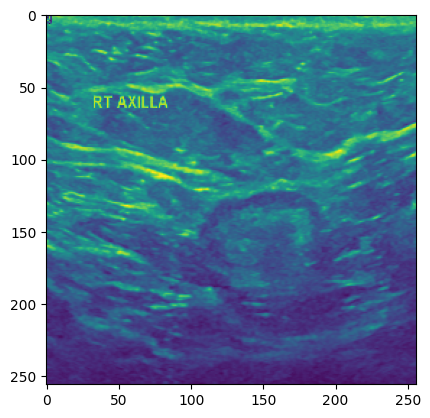

In [7]:
t = train_gen.__getitem__(3)[0]
p = train_gen.__getitem__(3)[1]
plt.imshow(t[0,:,:,0])

In [8]:
t.shape

(1, 256, 256, 1)

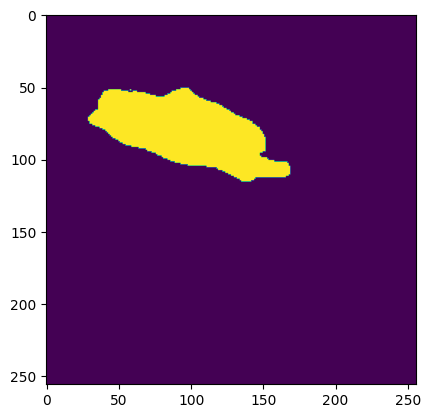

In [9]:
plt.imshow(p[0,:,:,0])

In [10]:
import encoder_layers as encoder_layers
import decoder_layers as decoder_layers
from resnet_v2 import  resnet_embeddings
from transformerskip import tskip
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import utils as utils
import math

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math

/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file 

In [11]:
def TransUNet(image_size=256, 
                patch_size=16, 
                hybrid=True,
                grid=(14,14), 
                hidden_size=768,
                n_layers=12,
                n_heads=12,
                mlp_dim=3072,
                dropout=0.1,
                decoder_channels=[256,128,64,16],
                n_skip=3,
                num_classes=1,
                final_act='sigmoid',
                pretrain=False,
                freeze_enc_cnn=True,
                name='TransUNet'):
    # Tranformer Encoder
    assert image_size % patch_size == 0, "image_size must be a multiple of patch_size"
    x = tf.keras.layers.Input(shape=(image_size, image_size, 1))

    # Embedding
    if hybrid:
        grid_size = grid
        patch_size = image_size // 16 // grid_size[0]
        if patch_size == 0:
            patch_size = 1

        resnet50v2, features = resnet_embeddings(x, image_size=image_size, n_skip=n_skip, pretrain=pretrain)
        print(len(features))
        for d in features:
            print(d.shape)
        if freeze_enc_cnn:
            resnet50v2.trainable = False
        y = resnet50v2.get_layer("conv4_block6_preact_relu").output
        x = resnet50v2.input
    else:
        y = x
        features = None

    y = tfkl.Conv2D(
        filters=hidden_size,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="embedding",
        trainable=True
    )(y)
    y = tfkl.Reshape(
        (y.shape[1] * y.shape[2], hidden_size))(y)
    y = encoder_layers.AddPositionEmbs(
        name="Transformer/posembed_input", trainable=True)(y)

    y = tfkl.Dropout(0.1)(y)

    # Transformer/Encoder
    for n in range(n_layers):
        y, _ = encoder_layers.TransformerBlock(
            n_heads=n_heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            name=f"Transformer/encoderblock_{n}",
            trainable=True
        )(y)
    y = tfkl.LayerNormalization(
        epsilon=1e-6, name="Transformer/encoder_norm"
    )(y)

    n_patch_sqrt = int(math.sqrt(y.shape[1]))

    y = tfkl.Reshape(
        target_shape=[n_patch_sqrt, n_patch_sqrt, hidden_size])(y)

    # Decoder CUP
    if len(decoder_channels):
        print('after reverting')
        features = features[::-1]
        for d in features:
            print(d.shape)
        features = tskip(features)
        for d in features:
            print(d.shape)
        features = features[::-1]
        for d in features:
            print(d.shape)
        y = decoder_layers.DecoderCup(decoder_channels=decoder_channels, n_skip=n_skip)(y, features)

    # Segmentation Head
    y = decoder_layers.SegmentationHead(num_classes=num_classes, final_act=final_act)(y)

    # Build Model
    model =  tfk.models.Model(inputs=x, outputs=y, name=name)
    
    # Load Pretrain Weights
    if pretrain:
        load_pretrained(model)
        
    return model


In [12]:
a = TransUNet()
a.compile(optimizer = tf.keras.optimizers.SGD(lr = 1e-3), loss=dice_loss, metrics = [dice_coef])
a.summary()

2023-09-14 11:50:22.890085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37724 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


3
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 64)
after reverting
(None, 128, 128, 64)
(None, 64, 64, 256)
(None, 32, 32, 512)
vocab size:  16384
vocab size:  16384
vocab size:  8192
(None, 128, 128, 64)
(None, 64, 64, 256)
(None, 32, 32, 512)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 64)
Model: "TransUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 1)  0           ['input_2[0][0]']                
                                                                     

                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, 64, 64, 256)  1024       ['conv2_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 64, 64, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 64, 64, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_blo

 conv3_block2_2_pad (ZeroPaddin  (None, 34, 34, 128)  0          ['conv3_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 32, 32, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
          

 conv4_block1_preact_relu (Acti  (None, 16, 16, 512)  0          ['conv4_block1_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 16, 16, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 16, 16, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

                                                                                                  
 flatten (Flatten)              (None, 16384)        0           ['max_pooling2d_5[0][0]']        
                                                                                                  
 flatten_1 (Flatten)            (None, 16384)        0           ['max_pooling2d_8[0][0]']        
                                                                                                  
 conv4_block5_2_pad (ZeroPaddin  (None, 18, 18, 256)  0          ['conv4_block5_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 emb_3 (Embedding)              (None, 8192, 4)      4000        ['flatten_2[0][0]']              
                                                                                                  
 emb_1 (Em

 tf.einsum_4 (TFOpLambda)       (None, 2, 8192, 163  0           ['tf.__operators__.getitem_4[0][0
                                84)                              ]',                              
                                                                  'tf.__operators__.getitem[0][0]'
                                                                 ]                                
                                                                                                  
 dense_1 (Dense)                (None, 16384, 8)     32          ['tf.__operators__.add[0][0]']   
                                                                                                  
 tf.einsum_2 (TFOpLambda)       (None, 2, 16384, 16  0           ['tf.__operators__.getitem_3[0][0
                                384)                             ]',                              
                                                                  'tf.__operators__.getitem[0][0]'
          

/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


                                                                 ]']                              
                                                                                                  
 dense_6 (Dense)                (None, 16384, 8)     32          ['tf.__operators__.add_1[0][0]'] 
                                                                                                  
 tf.einsum_8 (TFOpLambda)       (None, 2, 16384, 16  0           ['tf.einsum_3[0][0]',            
                                384)                              'tf.__operators__.getitem_5[0][0
                                                                 ]']                              
                                                                                                  
 tf.einsum_6 (TFOpLambda)       (None, 2, 16384, 16  0           ['tf.einsum_1[0][0]',            
                                384)                              'tf.__operators__.getitem_5[0][0
          

                                                                 ]']                              
                                                                                                  
 Transformer/encoderblock_3 (Tr  ((None, 256, 768),  7087872     ['Transformer/encoderblock_2[0][0
 ansformerBlock)                 (None, 12, None, N              ]']                              
                                one))                                                             
                                                                                                  
 tf.math.multiply_8 (TFOpLambda  (None, 2, 8192, 819  0          ['tf.einsum_16[0][0]']           
 )                              2)                                                                
                                                                                                  
 rearrange_8 (Rearrange)        (1, None, 2, 8192,   0           ['dense_8[0][0]']                
          

 )                                                                                                
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 16384, 1, 1)  0          ['conv2d[0][0]']                 
 )                                                                                                
                                                                                                  
 Transformer/encoderblock_9 (Tr  ((None, 256, 768),  7087872     ['Transformer/encoderblock_8[0][0
 ansformerBlock)                 (None, 12, None, N              ]']                              
                                one))                                                             
                                                                                                  
 tf.compat.v1.squeeze_2 (TFOpLa  (None, 8192)        0           ['max_pooling2d_14[0][0]']       
 mbda)    

In [13]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = r"/home/rabeea/logs/trans_atten_transunet2d/4layers_lr3_e4_f64_100_d8_h2_m4_withoutnorm_ablfull.h5"
EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_dice_coef',
    min_delta=0,
    patience=30,
    verbose=1,
    mode='max',
    baseline=None,
    restore_best_weights=False
)
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint,EarlyStopping]

In [ ]:
history = a.fit(train_gen,
                      validation_data=valid_gen,epochs=300,callbacks=callbacks_list)

Epoch 1/300


2023-09-14 11:53:40.215095: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801
2023-09-14 11:53:41.137940: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


400/400 [==============================] - 160s 348ms/step - loss: 0.9077 - dice_coef: 0.2366 - val_loss: 0.9218 - val_dice_coef: 0.2225
Epoch 2/300
400/400 [==============================] - 136s 340ms/step - loss: 0.8853 - dice_coef: 0.2589 - val_loss: 0.9034 - val_dice_coef: 0.2408
Epoch 3/300
400/400 [==============================] - 136s 340ms/step - loss: 0.8734 - dice_coef: 0.2708 - val_loss: 0.8996 - val_dice_coef: 0.2447
Epoch 4/300
400/400 [==============================] - 136s 341ms/step - loss: 0.8631 - dice_coef: 0.2811 - val_loss: 0.8823 - val_dice_coef: 0.2619
Epoch 5/300
400/400 [==============================] - 136s 341ms/step - loss: 0.8541 - dice_coef: 0.2901 - val_loss: 0.8485 - val_dice_coef: 0.2956
Epoch 6/300
400/400 [==============================] - 137s 343ms/step - loss: 0.8386 - dice_coef: 0.3056 - val_loss: 0.8259 - val_dice_coef: 0.3183
Epoch 7/300
400/400 [==============================] - 136s 341ms/step - loss: 0.8216 - dice_coef: 0.3226 - val_loss: 

Epoch 57/300
400/400 [==============================] - 135s 338ms/step - loss: 0.5386 - dice_coef: 0.6046 - val_loss: 0.6501 - val_dice_coef: 0.4931
Epoch 58/300
400/400 [==============================] - 135s 338ms/step - loss: 0.5360 - dice_coef: 0.6072 - val_loss: 0.6550 - val_dice_coef: 0.4881
Epoch 59/300
400/400 [==============================] - 136s 340ms/step - loss: 0.5388 - dice_coef: 0.6043 - val_loss: 0.6290 - val_dice_coef: 0.5141
Epoch 60/300
400/400 [==============================] - 135s 337ms/step - loss: 0.5304 - dice_coef: 0.6127 - val_loss: 0.6362 - val_dice_coef: 0.5069
Epoch 61/300
400/400 [==============================] - 135s 337ms/step - loss: 0.5305 - dice_coef: 0.6127 - val_loss: 0.6750 - val_dice_coef: 0.4681
Epoch 62/300
400/400 [==============================] - 136s 340ms/step - loss: 0.5181 - dice_coef: 0.6250 - val_loss: 0.6165 - val_dice_coef: 0.5266
Epoch 63/300
400/400 [==============================] - 135s 337ms/step - loss: 0.5156 - dice_coef: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 136s 341ms/step - loss: 0.4552 - dice_coef: 0.6875 - val_loss: 0.6117 - val_dice_coef: 0.5310
Epoch 86/300
400/400 [==============================] - 135s 338ms/step - loss: 0.4431 - dice_coef: 0.6996 - val_loss: 0.6277 - val_dice_coef: 0.5150
Epoch 87/300
400/400 [==============================] - 135s 337ms/step - loss: 0.4426 - dice_coef: 0.7001 - val_loss: 0.6323 - val_dice_coef: 0.5104
Epoch 88/300
400/400 [==============================] - 135s 336ms/step - loss: 0.4388 - dice_coef: 0.7038 - val_loss: 0.6231 - val_dice_coef: 0.5195
Epoch 89/300
400/400 [==============================] - 134s 336ms/step - loss: 0.4360 - dice_coef: 0.7066 - val_loss: 0.6307 - val_dice_coef: 0.5119
Epoch 90/300
400/400 [==============================] - 135s 337ms/step - loss: 0.4335 - dice_coef: 0.7091 - val_loss: 0.6252 - val_dice_coef: 0.5174
Epoch 91/300
400/400 [==============================] - 135s 337ms/step - loss: 0.4340 - dice_coef: 0.7086 - val_

In [ ]:
a.load_weights(filepath)

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
print('training dice: ',max(acc))
print('validation dice: ',max(val_acc))

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [ ]:
#test_gen = DataGen(image_size,testpath, batch_size=batch_size)
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for k in tqdm(range(len(testpath))):
    y_pred=a.predict(test_gen.__getitem__(k)[0])
    true_msk=test_gen.__getitem__(k)[1]
    y_pred_argmax=np.where(y_pred>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, true_msk))
    
#     except:
#         print(k)
#         break
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))